# ADMM applied in Neural Networks with Mnist dataset


In [62]:
# Preparation with environment for notebook
import random
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec

# Allow inline matplotlib figures appear in the notebook
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 10.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Allow auto-reload of external modules 
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Preprocessing and Loading of dataset

In [71]:
from NeuralNetwork.data_utils import *

# Load Mnist Data
mnistDir = "NeuralNetwork/MnistData"
X_train,Y_train,X_test,Y_test = getMnistData(mnistDir)

# Check the size of the training and test data.
print 'Training data shape: ', X_train.shape, X_train.dtype
print 'Training labels shape: ', Y_train.shape,Y_train.dtype
print 'Test data shape: ', X_test.shape
print 'Test labels shape: ', Y_test.shape

Training data shape:  (60000, 28, 28) float64
Training labels shape:  (60000,) int8
Test data shape:  (10000, 28, 28)
Test labels shape:  (10000,)


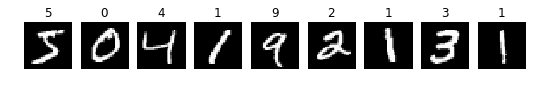

In [8]:
# Display part of the Mnist data
for xi in range(0,9):
    plt.subplot(1,10,xi+1)
    plt.imshow(X_train[xi])
    plt.axis('off')
    plt.title(Y_train[xi])

In [4]:
#Load dataset from tensorflow
import NeuralNetwork.TensorFlow.input_data as input_data
fake_data = False
train_dir = 'data'
batch_size = 55000
data_sets = input_data.read_data_sets(train_dir, fake_data).train
tfX, tfY = data_sets.next_batch(batch_size,fake_data)
print tfX.shape, tfY.shape

Extracting data/train-images-idx3-ubyte.gz
Extracting data/train-labels-idx1-ubyte.gz
Extracting data/t10k-images-idx3-ubyte.gz
Extracting data/t10k-labels-idx1-ubyte.gz
0 55000 55000
(55000, 784) (55000,)


## Predefined Functions

In [9]:
# Get MiniPatch
def getMiniPatch(X_train, Y_train, X_test, Y_test, trNum, teNum, transposed):
    # Subsample the data for more efficient code execution 
    trainNum = trNum
    mask = range(trainNum)
    #mask = range(5000,trainNum)
    Xtr = X_train[mask]
    Ytr = Y_train[mask]
    
    testNum = teNum
    mask = range(testNum)
    #mask = range(5000,5000+testNum)
    Xte = X_test[mask]
    Yte = Y_test[mask]
    
    # Reshape the image data into rows
    Xtr = np.reshape(Xtr, (Xtr.shape[0], -1))
    Xte = np.reshape(Xte, (Xte.shape[0], -1))
   
    # print Xtr.shape, Xte.shape
    if not transposed:
        return Xtr, Xtr, Ytr, Yte
    else:
        return preprocess(Xtr.T), Xte.T, Ytr, Yte

def preprocess(X):
    
#     # return X
#     X = X.astype(np.float64)
#     # Mean subtraction
#     X -= np.mean(X)  
#     # Normalization
   # X /= np.std(X, axis = 0)
    return X

def calLossWithTF(Y_tr, logits):
    with tf.Graph().as_default() as g:
        sess = tf.InteractiveSession()
        cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(
          logits, np.int64(Y_tr), name='xentropy')
        loss = tf.reduce_mean(cross_entropy, name='xentropy_mean')
    return sess.run(loss)

## Comparasion between ours and TF

### Train and predict with dataset from TF

In [6]:
import tensorflow as tf
import numpy as np
import NeuralNetwork.TensorFlow.simple_nn as tfnn
from NeuralNetwork.neural_network import *
import time

# Parameters initialization
trNum = batch_size
hiddenLayer = [300]
classNum = 10 
epsilon= 0.0001 

weightConsWeight = 10
activConsWeight = 15
iterNum = 20
hasLambda = True
tic = time.time()
calLoss = False

Extracting data/train-images-idx3-ubyte.gz
Extracting data/train-labels-idx1-ubyte.gz
Extracting data/t10k-images-idx3-ubyte.gz
Extracting data/t10k-labels-idx1-ubyte.gz


In [29]:

# Train our own neural network
X_tr, Y_tr = tfX.T, tfY
network = NeuralNetwork(X_tr, Y_tr, classNum, hiddenLayer, epsilon)
network.train(weightConsWeight, activConsWeight, iterNum, hasLambda, calLoss, lossType = 'smx',
              minMethod = 'prox', tau= 0.01, ite= 25)
# Predict
Ypred, z = network.predict(X_tr)
print 'Prediction accuracy: %f' %np.mean(Ypred == Y_tr)

# Calculate loss 
loss = calLossWithTF(Y_tr, z.T)
print 'Loss by us:', loss

[]   [[]]   [[], []]
Initializing a neural network with :  1  hidden layers, hidden layer dimension: [300]
(300, 784)
Prediction accuracy: 0.875000
Loss by us: 2.24867793747


In [33]:
print Y_tr[range(10)], tfY[range(10)]
print tfX.T.shape
print tfY.shape
np.sum(X_tr - tfX.T) 

[7 3 4 6 1 8 1 0 9 8] [7 3 4 6 1 8 1 0 9 8]
(784, 55000)
(55000,)


0.0

### Feed our network with W from TF

In [72]:
# Get trained weight from tensor flow
%prun w1,w2,loss_ft,logit = tfnn.getTrainedWeight(hiddenLayer[0])
print 'Loss by TF:',loss_ft

# Feed into our network
w = [np.zeros((0))]
w.append(w1.T)
w.append(w2.T)
z_us = network.predictByFeed(X_tr, w)
loss_us = calLossWithTF(Y_tr, z_us.T)
print 'Our side:'
print 'Prediction accuracy: %f' %np.mean(Ypred_ == Y_tr)
print 'Loss by us:', loss_us

Step 1999: loss = 0.51
 Loss by TF: 0.509063
Our side:
Prediction accuracy: 0.891800
Loss by us: 39.3942


In [52]:
print logit.shape,z_us.shape
#np.sum(logit - z_us)

i = range(54900,55000)
print z_us.T[i,:].shape
loss = calLossWithTF(Y_tr[i], z_us.T[i,:])
print loss

(100, 10) (10, 55000)
(100, 10)
0.421749


In [56]:
# Calculate loss of TF's W with our loss function
network = NeuralNetwork(X_tr[:,i], Y_tr[i], classNum, hiddenLayer, epsilon)
loss_us_ = network.softMaxLossTest(w)
print 'Loss cal by us with w from TF:', loss_us_

[]   [[]]   [[], []]
Initializing a neural network with :  1  hidden layers, hidden layer dimension: [300]
Loss cal by us with w from TF: 2.30258509251


## Test NeuralNetwork


In [15]:
Ypred = network.predict(X_te)

(300, 784)


In [1]:
# 0.880000
# print network.dataLoss
# print network.zConstrLoss[L-1]
# print network.aConstrLoss[L-1]

In [57]:
X_tr, X_te, Y_tr, Y_te = getMiniPatch(X_train, Y_train, X_test, Y_test, 6000, 1000, 1)
Ypred = network.predict(X_te)
print 'Prediction accuracy: %f' %np.mean(Ypred == Y_te)

Prediction accuracy: 0.802000


hasLambda =  True
Xtr:  (784, 55000) Xte:  (784, 10000) Ytr:  (55000,) Yte:  (10000,)
[]   [[]]   [[], []]
Initializing a neural network with :  1  hidden layers, hidden layer dimension: [300]
(300, 784)
(0,) (784, 55000)
Total training time: 757.963371s
(300, 784)


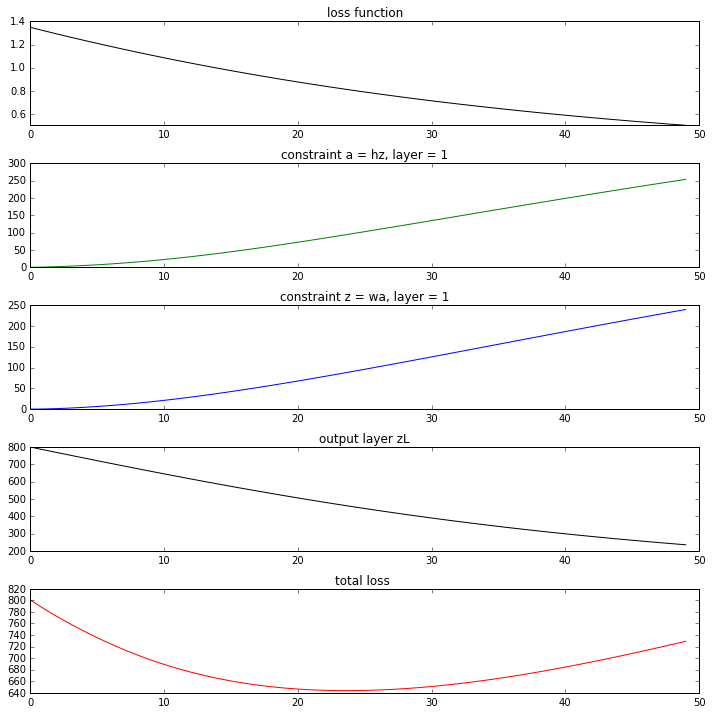

In [60]:
from NeuralNetwork.neural_network import *
import time


case = [(55000,10000)]#,(5000,50)]#,(500,10),(5000,10),(5000,500),(20000,500),(20000, 2000)]
lam = [True]
i = 0
for la in lam:
    print 'hasLambda = ',la
    for (trNum,teNum) in case:
        X_tr, X_te, Y_tr, Y_te = getMiniPatch(X_train, Y_train, X_test, Y_test, trNum, teNum, 1)
        print 'Xtr: ', X_tr.shape, 'Xte: ', X_te.shape, 'Ytr: ', Y_tr.shape, 'Yte: ', Y_te.shape
        
        # Initialize network
        hiddenLayer = [300]
        classNum = 10 
        epsilon= 0.0001 
        #epsilon = np.sqrt(2.0/trNum)
        network = NeuralNetwork(X_tr, Y_tr, classNum, hiddenLayer, epsilon)
        # Train
        weightConsWeight = 10
        activConsWeight = 15
        iterNum = 50
        hasLambda = 0
        tic = time.time()
        calLoss = True
        
        """ 
        Input:
        weightConsWeight, activConsWeight
        iterNum:    iteration to perform Admm updates
        hasLambda:  whether include Lambda update
        lossType:   one of {'hinge', 'msq', 'smx'}, default is 'smx'
        minMethod:  if lossType is 'smx', the method to minimize the zLastUpdate has to be specified (for it's not in closed form), 
                    it can be one of {'prox','gd','newton'}, default is 'prox';
        tau, ite:   if lossType is 'smx', the step size and iteration of gradient descent/proximal gradient have to be specified, 
                    default: tau=0.01, ite=25; 
        """
        #network.train(weightConsWeight, activConsWeight, iterNum, hasLambda,lossType = 'hinge')
        network.train(weightConsWeight, activConsWeight, iterNum, hasLambda, calLoss, lossType = 'smx',
                      minMethod = 'prox', tau= 0.01, ite= 25,initW = initW)
        toc = time.time()
        print 'Total training time: %fs' % (toc - tic)

        # Predict
        Ypred, z_ = network.predict(X_te)
       # print 'Prediction accuracy: %f' %np.mean(Ypred == Y_te)
        
        L = len(hiddenLayer)
        if calLoss:
            fig = plt.figure()
            gs = gridspec.GridSpec(5,L)
          
            dataLoss = fig.add_subplot(gs[0,:])
            dataLoss.set_title('loss function')
            dataLoss.plot(network.dataLoss, 'k-')

            for l in range(0,L):
                aloss = fig.add_subplot(gs[1,l])
                aloss.set_title('constraint a = hz, layer = %d' % (l+1))
                aloss.plot(network.aConstrLoss[l], 'g-')
                
                zloss = fig.add_subplot(gs[2,l])
                zloss.set_title('constraint z = wa, layer = %d' % (l+1))
                zloss.plot(network.zConstrLoss[l], 'b-')
                
#             lag = fig.add_subplot(gs[3,:])
#             lag.set_title('lagrange term')
#             lag.plot(network.lagraLoss, 'r-')

            
            zLLoss = fig.add_subplot(gs[3,:])
            zLLoss.set_title('output layer zL')
            zLLoss.plot(network.zConstrLoss[L], 'k-')
            
            total = fig.add_subplot(gs[4,:])
            total.set_title('total loss ')
            total.plot(network.totalLoss, 'r-')
            
            plt.tight_layout()
            plt.show()
        


In [61]:

# Calculate loss 
loss = calLossWithTF(Y_te, z_.T)
print 'Loss by us:', loss


Loss by us: 41261.1500051


In [31]:
print 'Prediction accuracy: %f' %np.mean(Ypred == Y_te)



Prediction accuracy: 0.937600


In [43]:
#network.W
w = network.W
len(w)
np.savez('weight.npz', w1=w[1], w2=w[2])

In [44]:
w = [0]
with np.load("weight.npz") as data:
    w.append(data['w1'])
    w.append(data['w2'])
print len(w)

3


In [45]:
initW = network.W

In [55]:
initW[1]

array([[ -8.54673819e+01,  -6.95011009e+06,   3.62151778e+06, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  4.97638950e+01,  -7.74334158e+06,   7.06292068e+06, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  3.67610030e+01,  -3.80845884e+06,   2.47856401e+06, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       ..., 
       [  4.81621075e+01,   1.25230413e+06,   3.80465231e+05, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  9.25450085e+01,   3.16308612e+06,   3.70571041e+06, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  7.82801142e+01,   2.85657460e+05,   3.20782105e+06, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00]])